<center>
   
# Dogs vs Cats VGG-16 Model Demo

EECS 351 Winter 2022 Project

 Iman El-Bawab, Shweta Pati, Ankita Mahajan

[Our project website Link](https://sites.google.com/umich.edu/classifying-cats-vs-dogs/home?authuser=1)

---

**NOTE:** We referenced this site for the following code. https://www.kaggle.com/code/perfectiods/dogs-vs-cats-two-cnn-models-vgg-16-resnet-50/notebook

**This notebook runs in under 15 minutes on Google Colab. Timing may vary on local machines.**

</center>







## **Imports**

In [60]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator

In [61]:
##REMOVE THIS CELL IF YOU ARE NOT RUNNING ON GOOGLE COLAB!!
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Load VGG16**

In [62]:
## Modifiable variables
input_shape = (200,200,3) ##based on our images 200x200x3
epochs = 5 ##can increase as needed -- tradeoff with size
batch_size = 16 ## candecrease as needed -- tradeoff with size
number_of_test_images = 40;
number_of_train_images = 200;
CorrectLabels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1];

## Load pretrained VGG16
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

## These layers were already trained. Do not train them again
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

# Specify networks output    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
## Flatten the output layer to one dimension
x = tf.keras.layers.GlobalMaxPool2D()(last_output)

## Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

## Add a dropout rate of 0.5
x = Dropout(0.5)(x)

## Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

## Define & compile our model
our_vgg = tf.keras.Model(pre_trained_model.input, x)
our_vgg.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), metrics=['accuracy'])

## **Train model**

In [63]:
train = train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
test = ImageDataGenerator(rescale=1./255)

## Prepare training & testing iterators from file path. MODIFY YOUR PATHS ACCORDING TO README!!
train_it = train.flow_from_directory('./drive/Shareddrives/EECS 351 Project/DEMO/cats_and_dogs_filtered/train' , class_mode='binary', shuffle=True, batch_size=batch_size, target_size=(200, 200))
test_it = test.flow_from_directory("./drive/Shareddrives/EECS 351 Project/DEMO/cats_and_dogs_filtered/validation", class_mode='binary', shuffle=False, batch_size=batch_size, target_size=(200, 200))

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [64]:
## Variables to prevent overfitting
earlystop = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, mode='auto') ##early stop = stop model learning after 10 epochs when val_loss value not decreased.
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001) ##reduce the learning rate when accuracy, for example, not increase for two continuous steps.
callbacks = [earlystop, learning_rate_reduction] ##combine as callbacks to pass into fit function

## Train on our data. This step takes time, be patient! Progress will be printed.
history = our_vgg.fit(train_it, epochs=epochs,validation_data=test_it,validation_steps=number_of_test_images//batch_size, steps_per_epoch=number_of_train_images//batch_size, callbacks=callbacks)

Epoch 1/5
12/12 [==============================] - 108s 9s/step - loss: 0.7695 - accuracy: 0.5489 - val_loss: 0.6477 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 2/5
12/12 [==============================] - 102s 9s/step - loss: 0.7328 - accuracy: 0.6033 - val_loss: 0.6004 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 3/5
12/12 [==============================] - ETA: 0s - loss: 0.7204 - accuracy: 0.5870
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
12/12 [==============================] - 104s 9s/step - loss: 0.7204 - accuracy: 0.5870 - val_loss: 0.6309 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 4/5
12/12 [==============================] - 103s 9s/step - loss: 0.6149 - accuracy: 0.6087 - val_loss: 0.6008 - val_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 5/5
12/12 [==============================] - 105s 9s/step - loss: 0.6247 - accuracy: 0.6304 - val_loss: 0.5694 - val_accuracy: 0.7500 - lr: 5.0000e-05


**Expected output (loss/accuracy varies run-to-run):**
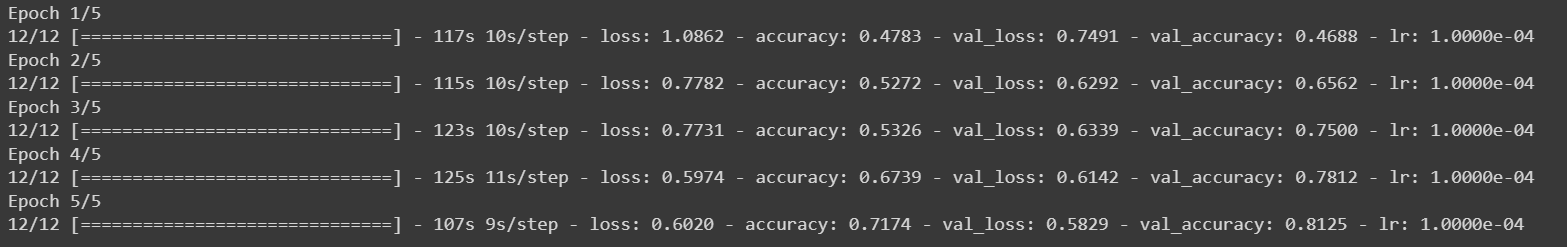

In [65]:
## Save weights from training
our_vgg.save_weights('model_wieghts.h5')
our_vgg.save('model_keras.h5')

## **Test model**

In [66]:
## Evaluate model and print accuracy & loss
loss, accuracy = our_vgg.evaluate(test_it, steps=len(test_it), verbose=0)
print('Test loss: > %.3f' % (loss))
print('Test accuracy: > %.3f' % (accuracy * 100.0)) ##Wow! With even only 200 training images, look how accurate our model is! 
## Compared to our one layer CNN that took 24 hours to run on our entire data set, this accuracy is EVEN BETTER!

## Predict labels of validation data using trained model 
predicted_labels = our_vgg.predict(test_it);
print("\nPredicted Labels:")
print(predicted_labels)

Test loss: > 0.569
Test accuracy: > 72.500

Predicted Labels:
[[0.42888585]
 [0.62202424]
 [0.54059774]
 [0.26991504]
 [0.5144015 ]
 [0.3468377 ]
 [0.33462584]
 [0.32859445]
 [0.45514652]
 [0.68585026]
 [0.22407767]
 [0.4331127 ]
 [0.34940344]
 [0.66243935]
 [0.34155086]
 [0.3314879 ]
 [0.37137341]
 [0.4342211 ]
 [0.33999336]
 [0.22497231]
 [0.5898721 ]
 [0.5415039 ]
 [0.55757827]
 [0.68739074]
 [0.46704167]
 [0.5791136 ]
 [0.69452006]
 [0.548322  ]
 [0.5813814 ]
 [0.5909004 ]
 [0.48190132]
 [0.43045866]
 [0.34934807]
 [0.51261055]
 [0.81297624]
 [0.7458941 ]
 [0.48646706]
 [0.63294923]
 [0.49455845]
 [0.65629876]]


**Expected output: (accuracy, loss, and predicted labels may vary)**

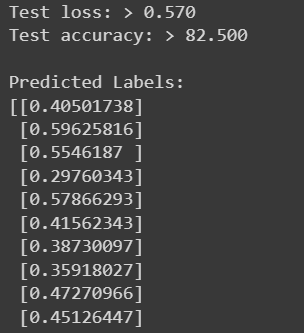


## Make graphs

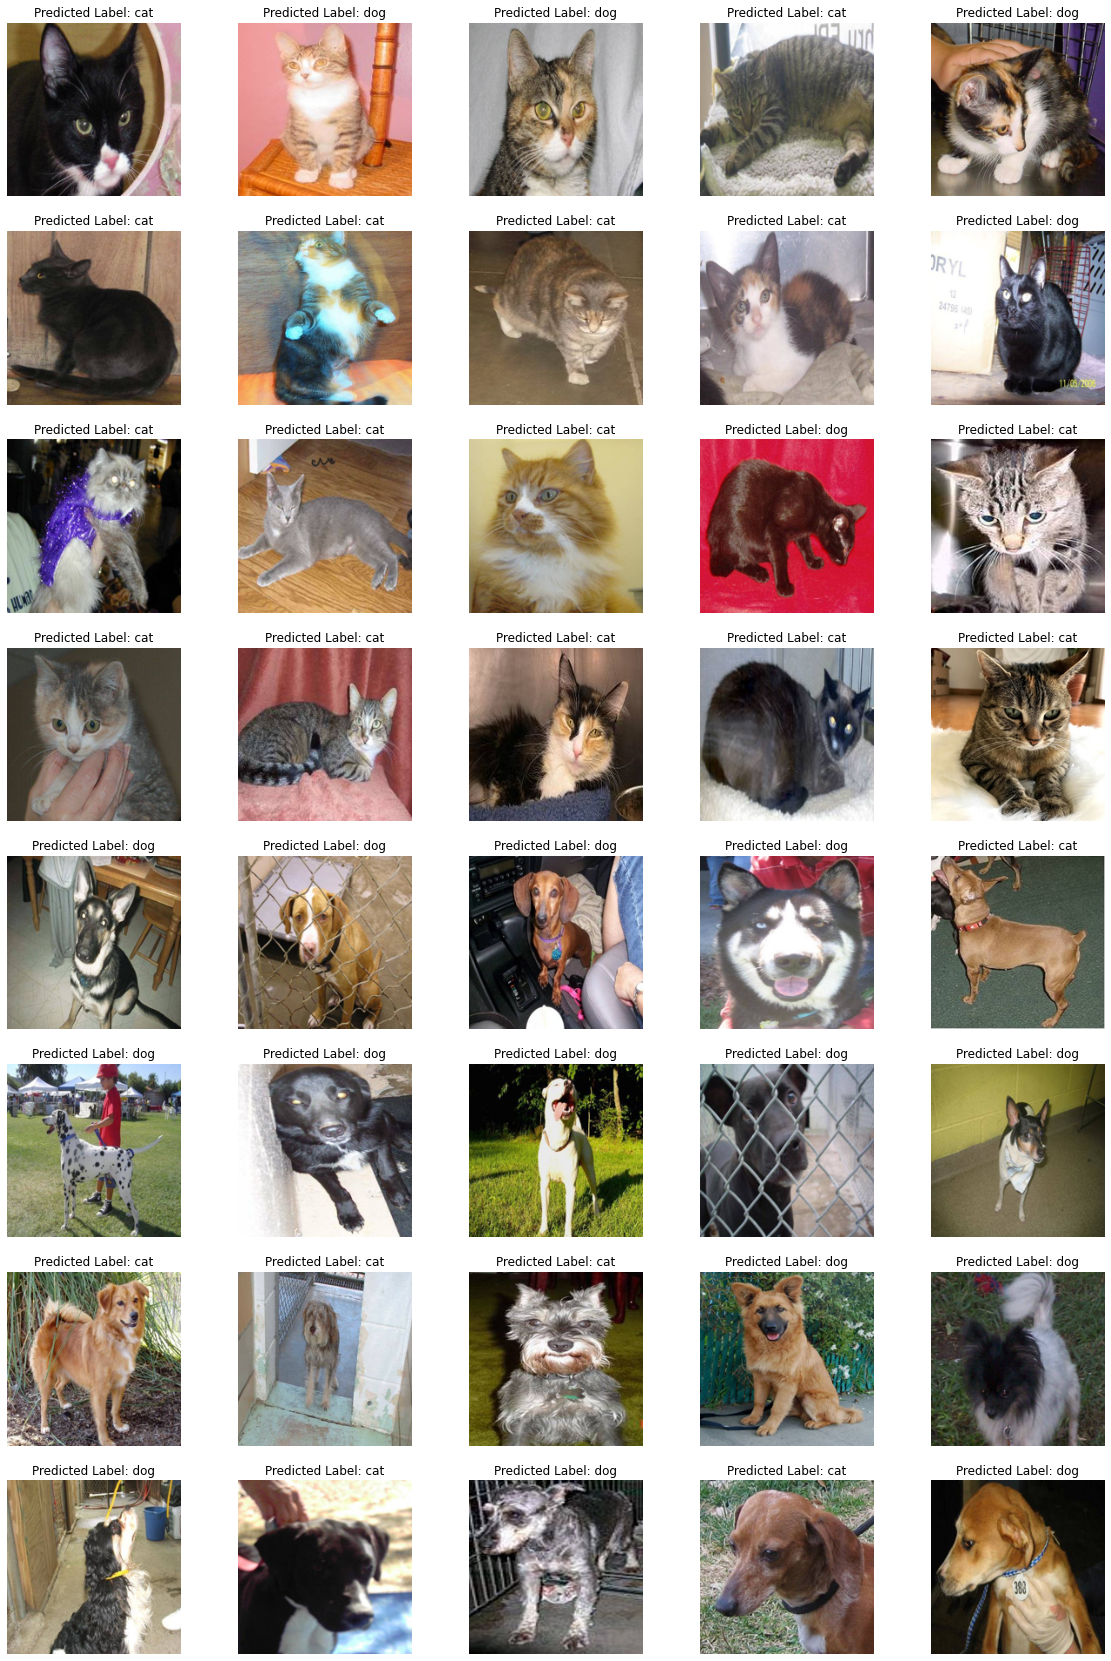

In [67]:
from os import listdir
from PIL import Image as PImage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# get binary values
predicted_labels_string = [];
for i in range(0,40):
  if predicted_labels[i] > 0.5:
    predicted_labels_string.append("dog");
  else:
    predicted_labels_string.append("cat");

# create figure
fig = plt.figure(figsize=(20,30))
def loadImages(path, i, z):
    imagesList = listdir(path)
    for image in imagesList:
        img = mpimg.imread(path + image)
        fig.add_subplot(8,5,z)
        plt.title("Predicted Label: %s" %predicted_labels_string[i]);
        plt.axis('off')
        plt.imshow(img)
        i = i+1;
        z = z+1;

## MODIFY YOUR PATH ACCORDING TO README!
pathCat = "./drive/Shareddrives/EECS 351 Project/DEMO/cats_and_dogs_filtered/validation/cats/"
loadImages(pathCat, 0, 1)
pathDog = "./drive/Shareddrives/EECS 351 Project/DEMO/cats_and_dogs_filtered/validation/dogs/"
loadImages(pathDog, 20, 21)

**Expected output: (trend may change)**

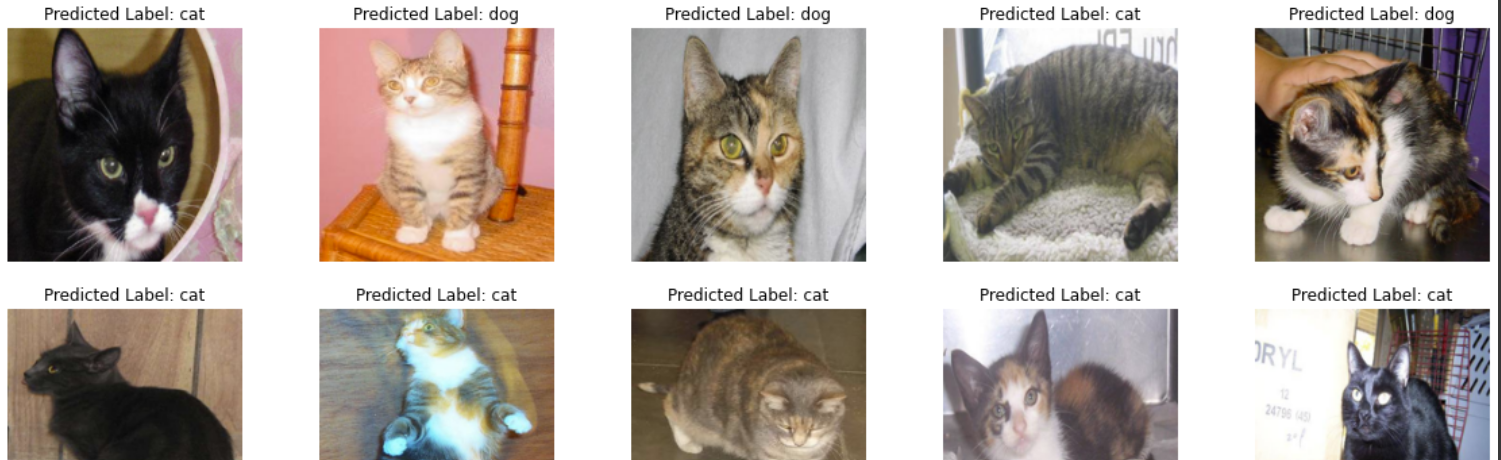

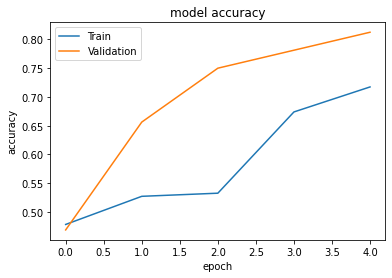

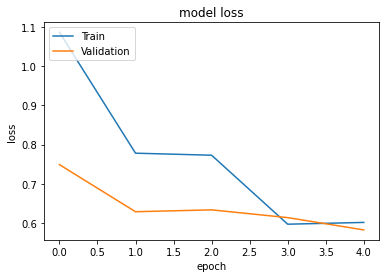

In [ ]:
## Plot losses & accuracy over epochs
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Expected output: (trends may vary)**

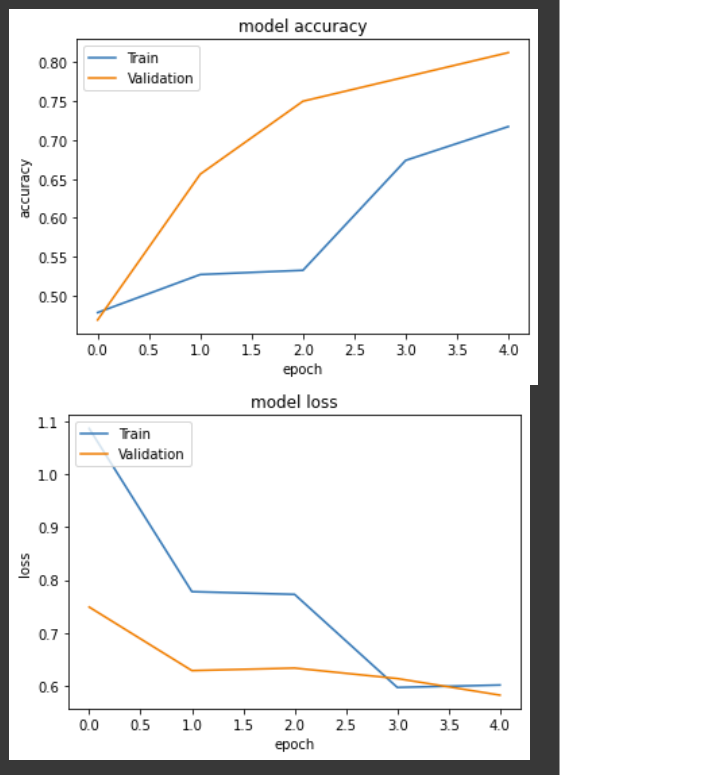